# FIFA 2018 Player Value Modelling - Novetta Skills Test

## Matthew Jacobsen
## 5/20/2021

### Problem Overview:
We have been provided with a set of data obtained from the FIFA 2018 soccer video game that contains information on player attributes, as modelled from real-world assessments, along with player information and value data.  We have been asked to:
1) Develop a machine learning model that can be used to predict the value of each player in Euros.  This model can use whatever technique we'd like, but we need to identify what features of the model have the greatest impact on the model's ability to predict.
2) Develop two unique research questions that this dataset can solve and answer those questions using an appropriate data science technique.

### Objective 1: Value Prediction Model
To start with, our data has been delivered as a comma-separated value file, which will make importing somewhat easier.  Prior to importing, I did modify the file to remove the dollar sign ($) prefixes in front of player pay, as this modification is more easily done via Excel.  We are going to try two different models to see which one works better - which will server as one of our unique research questions for Objective 2.  That question will be if there is a significant difference in the features that matter, should we choose a different modelling approach.

We'll start here by importing the packages needed for what we are going to attempt.  This will include standard numerical and data handling/visualization packages, along with several specialized packages from SciKit Learn. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans


import warnings # supress warnings
warnings.filterwarnings('ignore')

Next, we will import the data (with the $ characters already removed from the wage column).  In addition to importing the data, there are also several normalizations that will need to be done.  These include:
- converting the Value data into Euros, as opposed to Millions (indicated by M) and removing the Euro symbol
- quality control the Contract Valid Until field, as some full dates were included (these were probably data entry errors, but since we cannot be sure, its easier to just normalize them out).
- convert the height into inches, as opposed to feet and inches.
- remove the 'lbs' from the weight column
- recode the preferred foot column to binary (True/False) for the right foot.

Since we aren't totally sure which features will end up in the model at this point, we need to treat as much of the data as we can.  

In [2]:
soccer_df = pd.read_csv('Skills_Verification_Data_FIFA_18.csv')
soccer_df['Value'] = soccer_df['Value'].apply(lambda x: str(x)[1:])
soccer_df['Value'] = soccer_df['Value'].apply(lambda x: int(x[:x.find('.')]+x[x.find('.')+1:len(x)-1]+'00000') if '.' in x else int(x[:len(x)-1]+'000000'))
soccer_df['Contract Valid Until'] = soccer_df['Contract Valid Until'].apply(lambda x: x if len(str(x))==4 else None)
soccer_df['Height'] = soccer_df['Height'].apply(lambda x: int(x[:x.find("'")])*12 + int(x[x.find("'")+1:]))
soccer_df['Weight'] = soccer_df['Weight'].apply(lambda x: int(str(x)[:len(str(x))-3]))
soccer_df['Preferred Foot'] = soccer_df['Preferred Foot'].apply(lambda x: True if x=='Right' else False)
soccer_df.head()

,No,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000,565,...,75,96,33,28,26,6,11,15,14,8
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000,405,...,85,95,28,31,23,7,11,15,14,11
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000,290,...,81,94,27,24,33,9,9,15,15,11
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000,260,...,40,68,15,21,13,90,85,87,88,94
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000,355,...,79,88,68,58,51,15,13,5,10,13


At this point, we've done the data cleaning, but we will still need to standardize a few of the other features, as we want a numerical model in the end.  This means that we'll have to encode some of the potential features, so that we can use them in our model if needed.  Since all the features are numerical, we'll use simple ordinal encoding (e.g. 1,2,3,4,5,...) to accomplish this.  

In [3]:
cols_to_encode = [
    'Work Rate',
    'Position',
]

for col in cols_to_encode:
    enc = OrdinalEncoder()
    sub_data = np.array(soccer_df[col]).reshape(-1, 1)
    enc.fit(sub_data)
    soccer_df['enc_'+col] = enc.transform(sub_data)

soccer_df.head()

,No,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,enc_Work Rate,enc_Position
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000,565,...,33,28,26,6,11,15,14,8,7.0,21.0
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000,405,...,28,31,23,7,11,15,14,11,1.0,26.0
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000,290,...,27,24,33,9,9,15,15,11,2.0,14.0
3,3,193080,De Gea,27,Spain,91,93,Manchester United,72000000,260,...,15,21,13,90,85,87,88,94,7.0,5.0
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000,355,...,68,58,51,15,13,5,10,13,0.0,19.0


Now that we've handled most of the data normalization, we need to consider what features we want to include in our model.  This data set contains a wide array of features and there are several that are unlikely to matter and others that we do not want to include, because those are likely to bias the model in ways we would not want.  Let's get the full list of columns and then we can go through the logic leading to dropping certain features.

In [4]:
soccer_df.columns

Index(['No', 'ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential',
       'Club', 'Value', 'Wage', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Position', 'Jersey Number',
       'Joined', 'Contract Valid Until', 'Height', 'Weight', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'enc_Work Rate',
       'enc_Position'],
      dtype='object')

Our first reduction in features can now be done and is based on logic of the problem we are trying to solve.  Take the columns No, ID, and Name.  These are unique identifiers of the player or data row and are either unlikely to help or will bias the model (for example players with a lower No value are more likely to have high value).  In addition, Wage is going to be directly correlated to the Value of the player.  Since these are more likely to cause noise in our model, we'll leave them out. 

In addition, Club can be left out, as clubs that have more financial resources are more likely to value their players higher and pay them more. We can also drop the Joined, Jersey Number, and Contract Valid Until as these are unlikely to bear on the value of a player or would introduce superstition (Jersey Number) into the model that we do not want. We can also drop the unencoded Work Rate and Position columns, since we have recoded them.

Let's reduce our dataframe down and continue our analysis to see if we can identify a smaller set of features to use.  One way to do this is to plot the data against Value and see if there are any trends that are obvious.

In [5]:
reduced_soccer_df = soccer_df[['Age','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
                              'enc_Work Rate','enc_Position','Height','Weight','Crossing','Finishing','HeadingAccuracy',\
                              'ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl',\
                              'Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping',\
                              'Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision',\
                              'Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling',\
                              'GKKicking','GKPositioning','GKReflexes','Value']].copy()

reduced_soccer_df.head()

,Age,Preferred Foot,International Reputation,Weak Foot,Skill Moves,enc_Work Rate,enc_Position,Height,Weight,Crossing,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Value
0,31,False,5,4,4,7.0,21.0,67,159,84,...,96,33,28,26,6,11,15,14,8,110500000
1,33,True,5,4,5,1.0,26.0,74,183,84,...,95,28,31,23,7,11,15,14,11,77000000
2,26,True,5,5,5,2.0,14.0,69,150,79,...,94,27,24,33,9,9,15,15,11,118500000
3,27,True,4,3,1,7.0,5.0,76,168,17,...,68,15,21,13,90,85,87,88,94,72000000
4,27,True,4,5,4,0.0,19.0,71,154,93,...,88,68,58,51,15,13,5,10,13,102000000


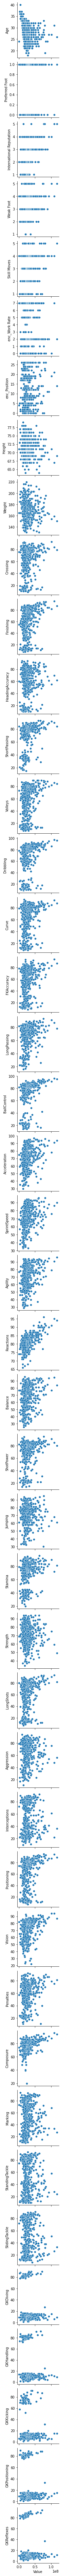

In [6]:
pp = sns.pairplot(
    data=reduced_soccer_df,
    x_vars = ['Value'],
    y_vars = ['Age','Preferred Foot','International Reputation','Weak Foot','Skill Moves',\
                              'enc_Work Rate','enc_Position','Height','Weight','Crossing','Finishing','HeadingAccuracy',\
                              'ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl',\
                              'Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping',\
                              'Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision',\
                              'Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling',\
                              'GKKicking','GKPositioning','GKReflexes'],
    diag_kind = None
)

Reviewing the charts above, what we are looking for (ideally) are features that show a correlation going from one side of the x axis to the other as we move vertically along the chart.  We can see that, while noise, Age certainly has a factor.  Older players have less value.  Intuitively, this makes sense as older players have less usable life and stamina (generally speaking) than younger players. 

In contrast, there are several features that don't appear to correlate strongly, such as Preferred Foot, Position, Work Rate, and Position.  In order to get some idea for what correlation we are seeing with value, let's take a look at a correlation matrix.

In [7]:
df_corr_ = reduced_soccer_df.corr()
df_corr_['Value']

Age                        -0.220359
Preferred Foot             -0.022656
International Reputation    0.423654
Weak Foot                   0.186319
Skill Moves                 0.231791
enc_Work Rate              -0.163543
enc_Position                0.115994
Height                     -0.138160
Weight                     -0.087131
Crossing                    0.185544
Finishing                   0.305001
HeadingAccuracy             0.093044
ShortPassing                0.246763
Volleys                     0.268087
Dribbling                   0.243432
Curve                       0.235706
FKAccuracy                  0.241397
LongPassing                 0.210275
BallControl                 0.257387
Acceleration                0.281586
SprintSpeed                 0.258000
Agility                     0.297495
Reactions                   0.623651
Balance                     0.225658
ShotPower                   0.196308
Jumping                     0.039856
Stamina                     0.199399
S

Based upon the correlations we see here, we need to determine what thresholding we will use for inclusion of a feature.  Generally, weak correlations are considered to be 0.3 to 0.5, moderate correlations from 0.5 to 0.7, and strong above, regardless of whether the value is positive or negative.  For this purpose, we will keep weak correlations, but extend the range to 0.2.  If this produces a noisy result, then we can step back to a simpler model.

In [8]:
sub_corr_df = pd.DataFrame(zip(list(df_corr_.index), list(df_corr_.Value)), columns=['Feature','Corr'])
features = list(sub_corr_df[abs(sub_corr_df['Corr']) >= 0.2]['Feature'])
features

['Age',
 'International Reputation',
 'Skill Moves',
 'Finishing',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'LongShots',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Value']

Now we have our features that appear to correlate and don't introduce any obvious problems or biases into our model.  In order to make predictions and test, we'll now break our data set up into a training and test set, with the test set being 20% of the overall data set.

In [9]:
df_train, df_test = train_test_split(reduced_soccer_df, test_size=0.2, random_state=10)
X_train = np.array(df_train[features[:len(features)-1]])
y_train = np.squeeze(df_train[features[-1:]])
X_test = np.array(df_test[features[:len(features)-1]])
y_test = np.squeeze(df_test[features[-1:]])

y_test

315     8000000
218    13000000
257    22500000
102     9000000
173    33000000
         ...   
411     6000000
98     30500000
50     45000000
317     3000000
34     46000000
Name: Value, Length: 101, dtype: int64

Just to make sure we did everything right, let's check the shape of the different data sets.  Ideally, we want our y data sets to be of (n, ) shape and the x data sets to be of (n, 21).  In this case, n is the number of data points and should be the same between the x and y sets.  

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 21) (101, 21) (400,) (101,)


For the first attempt at fitting, we are going to use a polynomial regressor, which is the simplest kind of model we could do on numerical data.  Given the fact that there are 21 features that might be of interest, we'll try a few different polynomial sizes to see what works best.  

In [11]:
degrees = [1,2,3,4]

y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i,degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    y_train_pred[:,i] = model.predict(X_train)
    y_test_pred[:,i] = model.predict(X_test)

Next, let's see how the model did.  We'll use r$^{2}$, mean squared error, and mean absolute error as a first look to see whats happening.

In [12]:
for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:,i]),2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:,i]),2)
    mse = mean_squared_error(y_test, y_test_pred[:,i])
    mae = mean_absolute_error(y_test, y_test_pred[:,i])
    print("Polynomial Degree {0}: train score={1}, test score={2} mse={3} mae={4}".format(degree,train_r2,test_r2,mse,mae))

Polynomial Degree 1: train score=0.64, test score=0.6 mse=94371460981186.38 mae=7960812.817284443
Polynomial Degree 2: train score=0.94, test score=0.44 mse=132461533689708.83 mae=8823574.148523742
Polynomial Degree 3: train score=1.0, test score=-1.05 mse=487825256725463.94 mae=15083197.50624617
Polynomial Degree 4: train score=1.0, test score=-0.66 mse=393809455687672.0 mae=12893864.71675509


Based upon the information we have from looking at the various possible polynomial degrees, polynomial fitting is not really helping us.  With each successive degree of fit, our test score gets worse, while the training score gets better.  So, we are best off with a linear model. 

Just to revisit, our linear model produces the following scores:

In [13]:
lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)
y_train_pred = lin_regressor.predict(X_train)
y_pred = lin_regressor.predict(X_test)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
test_r2 = sklearn.metrics.r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Linear Regressor Results:")
print("Training Set Score = {} \n Test Set Score={} \n Mean Squared Error={} \n Mean Absolute Error={}".format(train_r2,test_r2,mse,mae))

Linear Regressor Results:
Training Set Score = 0.6365833464340469 
 Test Set Score=0.6033642835139383 
 Mean Squared Error=94371460981186.44 
 Mean Absolute Error=7960812.817284448


We need to keep in mind that the scores above are relevant on a single linear regressor, with our given training and test data set.  One method to get a better idea of how our model will perform is to do cross validation and look at the model average accuracy and the standard deviation of that accuracy.  

In [14]:
scores = cross_val_score(estimator = lin_regressor, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(scores.mean() * 100))
print("Standard Deviation: {:.2f} %".format(scores.std() * 100))

Accuracy: 52.84 %
Standard Deviation: 15.72 %


So, our linear regressor is about 53% accurate and the accuracy deviates by 16 percent.  While this accuracy is not great, it is mostly better than a coin flip.  Given that we are trying to predict player value, that's not bad.

Now, to check some of our intuition from earlier.  What features had the greatest impact on our linear model?

Feature Number: 0, Feature: Age, Score:-2178086.79305
Feature Number: 1, Feature: International Reputation, Score:7247156.95151
Feature Number: 2, Feature: Skill Moves, Score:-686498.53754
Feature Number: 3, Feature: Finishing, Score:477147.04929
Feature Number: 4, Feature: ShortPassing, Score:41915.02021
Feature Number: 5, Feature: Volleys, Score:-140892.29357
Feature Number: 6, Feature: Dribbling, Score:-238349.46390
Feature Number: 7, Feature: Curve, Score:-96838.82260
Feature Number: 8, Feature: FKAccuracy, Score:90660.28213
Feature Number: 9, Feature: LongPassing, Score:84703.60383
Feature Number: 10, Feature: BallControl, Score:-70570.15402
Feature Number: 11, Feature: Acceleration, Score:178505.70734
Feature Number: 12, Feature: SprintSpeed, Score:-19869.46375
Feature Number: 13, Feature: Agility, Score:40599.97854
Feature Number: 14, Feature: Reactions, Score:1612899.52244
Feature Number: 15, Feature: Balance, Score:-51215.37248
Feature Number: 16, Feature: LongShots, Score:387

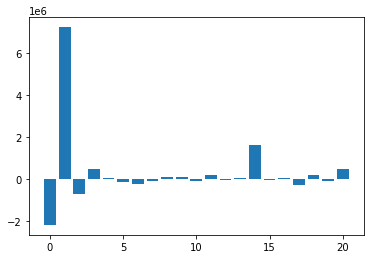

In [15]:
lr_importance = lin_regressor.coef_
for i,v in enumerate(lr_importance):
    print('Feature Number: %.d, Feature: %s, Score:%.5f' % (i, features[i],v))
plt.bar([x for x in range(len(lr_importance))], lr_importance)
plt.show()

From the list and chart above, the features that had the strongest impact on our model were:

1) International Reputation : This feature shouldn't surprise us.  The more well known a player is, the more people will pay to see them.  As a result, the more valuable they are to the club and the higher pay they can command.

2) Age : As with the reputation, Age should not surprise us.  As people age, their stamina (typically) goes down, which would result in less capability to play.  The negative impact here just means that as age increases, value goes down.  This matches our intuition.

3) Reactions : This one may be slightly less intuitive, but here's a stab at an explanation (from a non-soccer person).  Assuming that higher reaction ratings mean a player that can respond quicker to changes in the situation around them, reaction ratings then correlate to awareness of the games state.  More awareness means more ability to respond and change the direction if needed.  This **could** correlate with better team performance, although the impact of this feature shows that the correlation is not highly impactful, when compared with reputation.

4) Finishing : This feature may be somewhat surprising.  You would think that someone who finishes stronger would command a better value, but this feature correlates negatively, meaning the opposite.  That would indicate that player value weighs more towards those who start well. 


Now, we could obviously do better (in theory) with our model than a coin flip.  But, what impact would that have on the features that matter?  Let's take a look in our first research question.

### Unique Research Question 1: Do the features of importance for the model stay the same with a different Machine Learning approach?

In comparison to a vanilla Linear Regressor, there are many other potential models.  We would like to assume that all of these will weigh the features in a similar way, but do they?  

#### Why does this matter?

As with any use of machine learning, we are *not* developing actual theoretical bases for our predictions.  What we are actually doing is looking for correlations that enable us to predict.  From our polynomial fitting above, it is easy to see that different approaches will result in different model predictive abilities, but we would like to think that models would favor the same features.  Let's test that through use of a Gradient Boosting Regressor. 

The advantages of this approach is that the Gradient Boosting Regressor can find a more complicated model, meaning that it can make better predictions, in theory.  However, this also results in a more complicated and unintelligible model that may also be more computationally demanding. 

Given that both the Linear Regressor and the Gradient Boosting Regressor use the same inputs, we don't need to do much to fit our model, so let's look and see what we get for our metrics from earlier.

In [16]:
regressor = GradientBoostingRegressor(n_estimators = 500)
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_pred = regressor.predict(X_test)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
test_r2 = sklearn.metrics.r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("train score = {} test score={} mse={} mae={}".format(train_r2,test_r2,mse,mae))

train score = 0.999196935631811 test score=0.8537512195898058 mse=34796944653146.89 mae=4824162.578658454


At first blush, we seem to have done significantly better than the linear regressor.  We were able to predict our test data with 86% accuracy.  Let's check with cross validation and see how that holds up, remembering that we lost about 12% from the Linear Regressor accuracy when we generalized. 

In [17]:
scores = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(scores.mean() * 100))
print("Standard Deviation: {:.2f} %".format(scores.std() * 100))

Accuracy: 72.16 %
Standard Deviation: 12.12 %


So the Gradient Boosting Regressor pulled us from a coin flip to a 3/4 chance, on average, of a positive prediction.  That's quite good.  Even on the low end of our accuracy, we are still right 6/10 times.  So, now for the answer to our research question, what features mattered most here?

Feature Num: 0, Feature: Age, Score:0.11583
Feature Num: 1, Feature: International Reputation, Score:0.02915
Feature Num: 2, Feature: Skill Moves, Score:0.00345
Feature Num: 3, Feature: Finishing, Score:0.05240
Feature Num: 4, Feature: ShortPassing, Score:0.03270
Feature Num: 5, Feature: Volleys, Score:0.01034
Feature Num: 6, Feature: Dribbling, Score:0.02712
Feature Num: 7, Feature: Curve, Score:0.00960
Feature Num: 8, Feature: FKAccuracy, Score:0.04175
Feature Num: 9, Feature: LongPassing, Score:0.01152
Feature Num: 10, Feature: BallControl, Score:0.16751
Feature Num: 11, Feature: Acceleration, Score:0.00983
Feature Num: 12, Feature: SprintSpeed, Score:0.01602
Feature Num: 13, Feature: Agility, Score:0.00706
Feature Num: 14, Feature: Reactions, Score:0.38382
Feature Num: 15, Feature: Balance, Score:0.01056
Feature Num: 16, Feature: LongShots, Score:0.02556
Feature Num: 17, Feature: Positioning, Score:0.00577
Feature Num: 18, Feature: Vision, Score:0.01477
Feature Num: 19, Feature: Pe

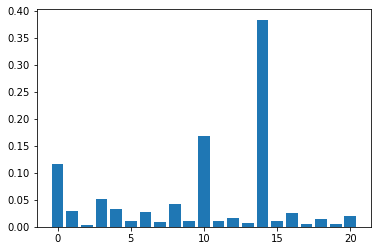

In [18]:
gb_importance = regressor.feature_importances_
for i,v in enumerate(gb_importance):
    print('Feature Num: %.d, Feature: %s, Score:%.5f' % (i, features[i],v))
plt.bar([x for x in range(len(gb_importance))], gb_importance)
plt.show()

With our new, better regressor, we got ...... a similar, but different, set of important features.  This time around, the important features were:
1) Reactions

2) Ball Control

3) Age

4) Finishing

As with the linear regressor, the Gradient Boosting Regressor agreed that Age was important.  They also agreed that reactions was important.  However, the Gradient Boosting Regressor seems to be favoring the players ability to handle the ball over their reputation.  From the standpoint of a club, someone who plays well would (naively, maybe) seem to be more important than someone who is well known.  The good news, is our Gradient Boosting Regressor seems to pull that out well.

### Unique Research Questions 2: What age, on average, are players at the best based upon the skills data available?

Now, for our second unique research question.  Soccer clubs are interested in having the best players they can get, but also in keeping those players as long as possible.  On the contrary, the players will get injured and generally age and lose the ability to play as well as they used to.  So, what age would clubs expect the best performance from their players? Let's see if we can find out.

We'll start by taking all of the relevant performance metrics out (with the exception of overall and potential, as those are less defined than the more specific ratings).  

In [46]:
reduced_soccer_df2 = soccer_df[['Age', 'Crossing','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']].copy()
reduced_soccer_df2

,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,84,95,70,90,86,97,93,94,87,...,75,96,33,28,26,6,11,15,14,8
1,33,84,94,89,81,87,88,81,76,77,...,85,95,28,31,23,7,11,15,14,11
2,26,79,87,62,84,84,96,88,87,78,...,81,94,27,24,33,9,9,15,15,11
3,27,17,13,21,50,13,18,21,19,51,...,40,68,15,21,13,90,85,87,88,94
4,27,93,82,55,92,82,86,85,83,91,...,79,88,68,58,51,15,13,5,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,26,72,69,48,78,74,87,80,83,71,...,75,75,39,35,35,6,14,7,6,12
497,27,79,77,38,84,63,81,81,79,70,...,66,65,60,23,16,15,12,16,13,12
498,28,78,75,53,82,69,84,80,75,74,...,77,78,54,36,32,15,5,14,13,7
499,27,66,79,93,76,83,66,63,66,64,...,64,77,44,43,37,16,10,8,8,11


While we could do a predictive approach to this data, we are more interested in just generating insights into the data.  In order to accomplish this, we will use the attributes we have and make an aggregate metric and look to see if this metric has some clear relation with the age of the player.  There are many approaches to this, but we can assume that there is some overall "aggregate" value that would represent all of these features and one possible aggregate is that of a straight sum of values.

In [49]:
reduced_soccer_df2['Aggregate Metric'] = reduced_soccer_df2.iloc[:,4:34].sum(axis=1)

reduced_soccer_df2.head()

,Age,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Aggregate Metric
0,31,84,95,70,90,86,97,93,94,87,...,96,33,28,26,6,11,15,14,8,2041
1,33,84,94,89,81,87,88,81,76,77,...,95,28,31,23,7,11,15,14,11,2045
2,26,79,87,62,84,84,96,88,87,78,...,94,27,24,33,9,9,15,15,11,1998
3,27,17,13,21,50,13,18,21,19,51,...,68,15,21,13,90,85,87,88,94,1394
4,27,93,82,55,92,82,86,85,83,91,...,88,68,58,51,15,13,5,10,13,2126


Now that we have our aggregate value, along with player age, let's see what this looks like.

Text(0.5, 1.0, 'Aggregated Attributes by Age Group')

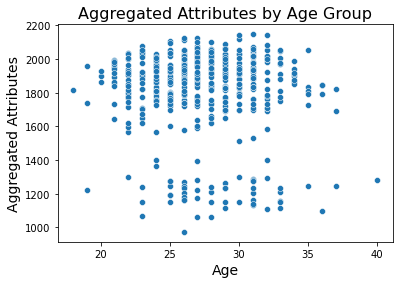

In [50]:
data = reduced_soccer_df2[['Age','Aggregate Metric']].copy()
sns.scatterplot(data=data, x='Age', y='Aggregate Metric')
# Put the axis labels on the plot
plt.ylabel('Aggregated Attributes', size=14)
plt.xlabel('Age',size=14)
# Put the chart title on the plot
plt.title("Aggregated Attributes by Age Group", size=16)

Now this is an interesting result.  Our aggregated attribute metric appears to create clusters of players.  Since these appear to cluster by our aggregated attribute, we'll call our clusters "Performance Cluster".  Even better, there appears to be trends for each of these clusters.  

In order to capture this insight for further analysis, we'll need to find a way to represent our clusters. Let's use a KMeans clustering approach to classify our players into groups and then we can generate some statistical results for the groups that might help explore this insight further.  

In [51]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

X = data[['Age','Aggregate Metric']]

y_km = km.fit_predict(X)

data['Performance Cluster'] = y_km
data['Performance Cluster'] = data['Performance Cluster'].apply(lambda x: 'High' if x==0 else 'Low')
data.head()

,Age,Aggregate Metric,Performance Cluster
0,31,2041,High
1,33,2045,High
2,26,1998,High
3,27,1394,Low
4,27,2126,High


With our players separated into their performance clusters, we can plot the clusters with the cluster centers for each.  This will visually show us where the KMeans algorithm believes the cluster centers are.  

Text(0.5, 1.0, 'Aggregated Attributes by Age Group\n with Cluster Centers')

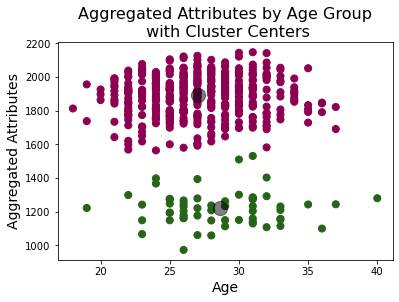

In [52]:
plt.scatter(X['Age'], X['Aggregate Metric'], c=y_km, s=50, cmap='PiYG')
centers=km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], c="black", s=200, alpha=0.5)
# Put the axis labels on the plot
plt.ylabel('Aggregated Attributes', size=14)
plt.xlabel('Age',size=14)
# Put the chart title on the plot
plt.title("Aggregated Attributes by Age Group\n with Cluster Centers", size=16)

With our clusters made and visualized, we can return to our original research question.  How does the player performance vary with age? Well, one conclusions is that it depends upon the performance cluster the player falls into, but we can gain better insight by splitting our players into age clusters and looking at a box plot for each of those clusters.

In [53]:
divisions = [
    data['Age'].between(15,19),
    data['Age'].between(20,24),
    data['Age'].between(25,29),
    data['Age'].between(30,34),
    data['Age'].between(35,39),
    data['Age'].between(40,49),
]

values = ['15-19','20-24','25-29','30-34','35-39','40-49']

data['Division'] = np.select(divisions, values, 0)
data.head()

,Age,Aggregate Metric,Performance Cluster,Division
0,31,2041,High,30-34
1,33,2045,High,30-34
2,26,1998,High,25-29
3,27,1394,Low,25-29
4,27,2126,High,25-29


<function matplotlib.pyplot.show(close=None, block=None)>

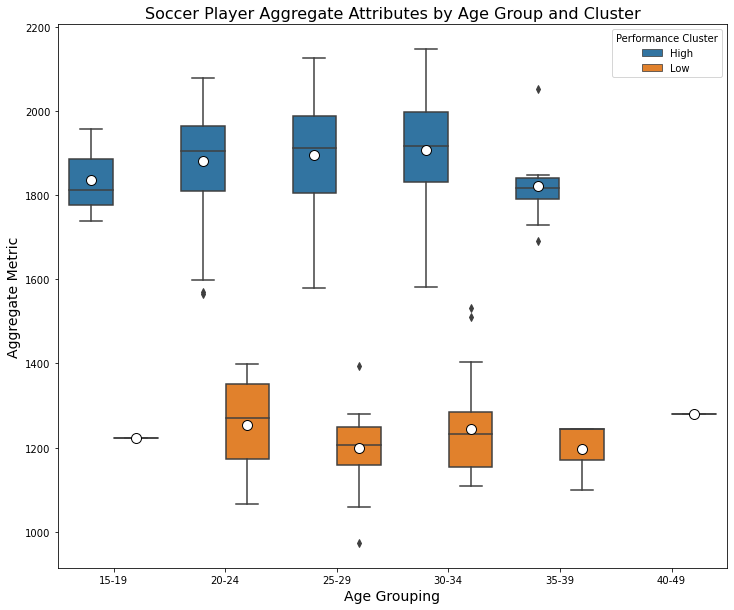

In [56]:
# Create our plot variables
fig, ax = plt.subplots(1,1,figsize=(12,10))
# Use Seaborn's boxplot to plot the Net Time by Gender and include the mean values on plot
sns.boxplot(x='Division', 
            hue='Performance Cluster',
            y='Aggregate Metric', 
            order=values,
            data=data, 
            showmeans=True,
            meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"}
           )
# Put the axis labels on the plot
plt.ylabel('Aggregate Metric', size=14)
plt.xlabel('Age Grouping',size=14)
# Put the chart title on the plot
plt.title("Soccer Player Aggregate Attributes by Age Group and Cluster", size=16)
plt.show

With that, we have a result that can help us to answer our question (along with providing some further detail.  

1) By following the marked means (white circles) in the box plot above, we can see that for the High Performance players, our aggregate metric drops off between the 30-34 and 35-39 groups.  This indicates that, as club managers, they should anticipate High Performance players to drop off in ability around 34-35.  Further data in the 40-49 range would help to understand whether this trend continues.

2) In contrast, players in the Low Performance cluster appear both steady in their performance and stay capable of playing longer than the High Performance cluster does.  This would be expected, given that the High Performance cluster would also be more prone to injury.  

3) The High Performance players also seem to start younger than the Low Performance Players.  This could just be an artifact of the data, so we need to be careful with this result, but the mean age for each cluster is different by about 3-4 years, based upon the clustering chart earlier.  

4) The final conclusion that we can draw is that the results for the Low Performance cluster have less variation in the aggregate attributes metric.  As with the previous conclusion, this may be an artifact of the data, but if real, this would indicate that the High Performance players are more variable in their attributes than the Low Performance players.  This could mean that Low Performance players are more reliable or consistent in their performance.  